# Single pixel and Percentage wise comparison

(28, 28)


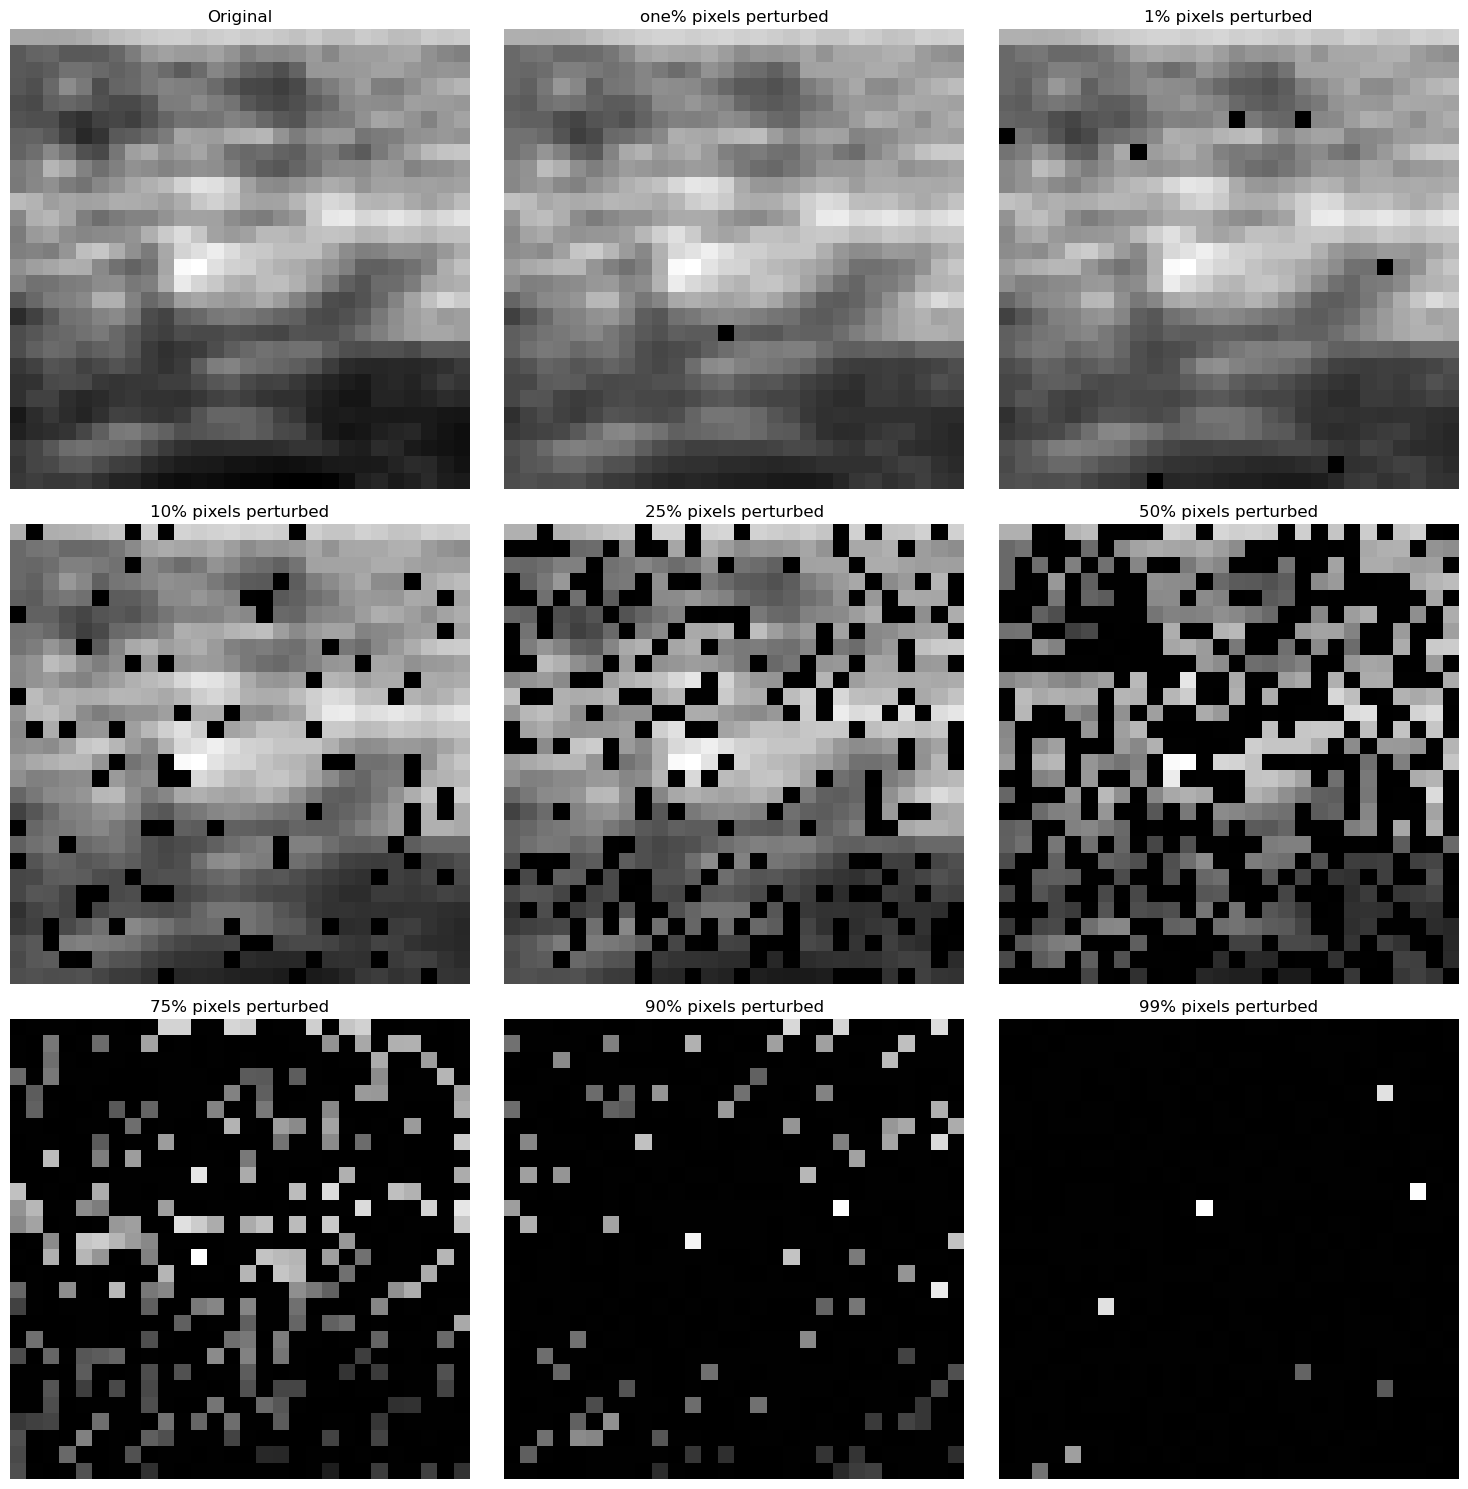

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from dataset import perturb_image_percentage

dataset_path = "/home/localssk23/.medmnist/breastmnist.npz"
data = np.load(dataset_path)
image = data['train_images'][0]
print(image.shape)

# Create plots for different percentages
percentages = ['one', 1, 10, 25, 50, 75, 90, 99]
n_rows = 3
n_cols = 3

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 15))
axes = axes.ravel()

# Plot original image
axes[0].imshow(image.squeeze(), cmap='gray')
axes[0].set_title('Original')
axes[0].axis('off')

# Plot perturbed images
for i, percent in enumerate(percentages):
    perturbed = perturb_image_percentage(image, percent)
    axes[i+1].imshow(perturbed.squeeze(), cmap='gray')
    axes[i+1].set_title(f'{percent}% pixels perturbed')
    axes[i+1].axis('off')

plt.tight_layout()
plt.show()

(28, 28, 3)


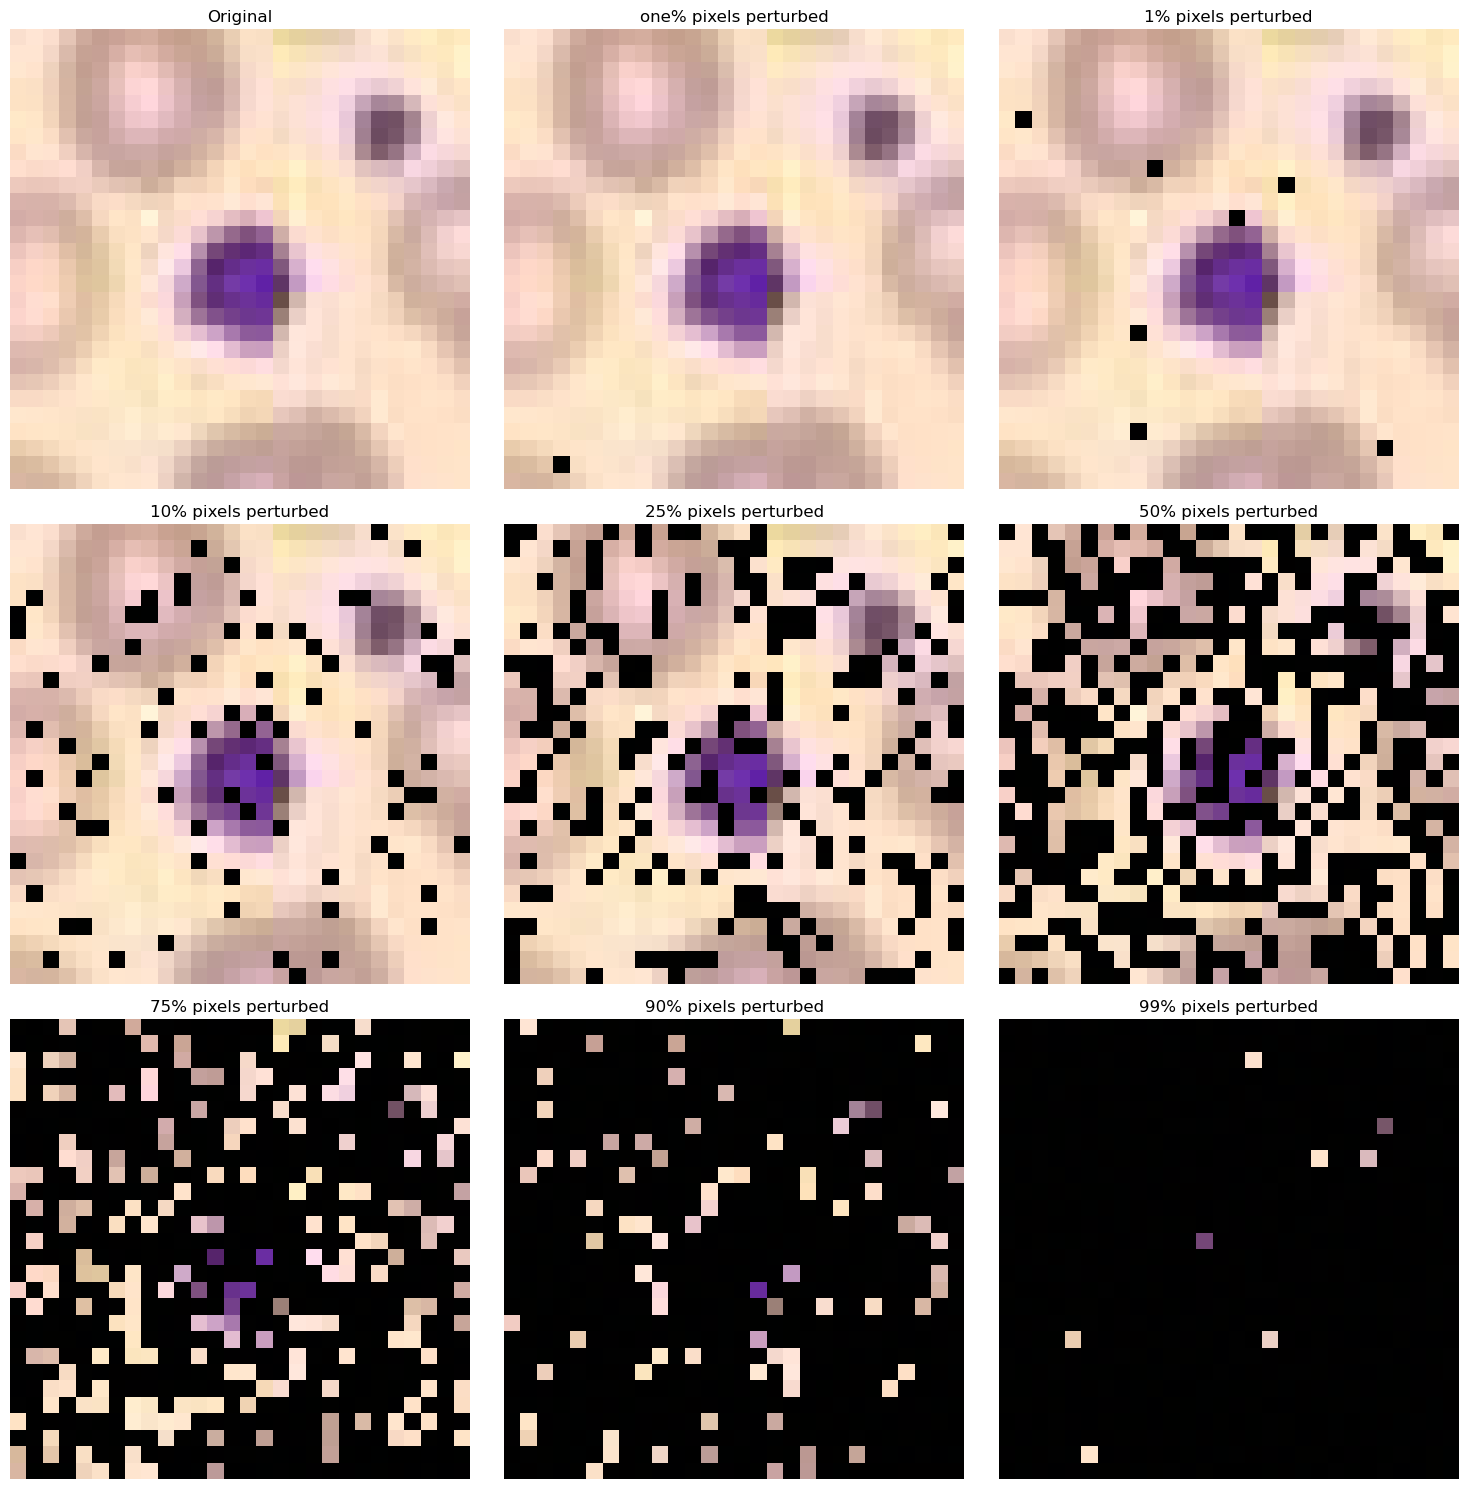

In [2]:
dataset_path = "/home/localssk23/.medmnist/bloodmnist.npz"
data = np.load(dataset_path)
image = data['train_images'][0]
print(image.shape)

# Create plots for different percentages
percentages = ['one', 1, 10, 25, 50, 75, 90, 99]
n_rows = 3
n_cols = 3

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 15))
axes = axes.ravel()

# Plot original image
axes[0].imshow(image.squeeze(), cmap='gray')
axes[0].set_title('Original')
axes[0].axis('off')

# Plot perturbed images
for i, percent in enumerate(percentages):
    perturbed = perturb_image_percentage(image, percent)
    axes[i+1].imshow(perturbed.squeeze(), cmap='gray')
    axes[i+1].set_title(f'{percent}% pixels perturbed')
    axes[i+1].axis('off')

plt.tight_layout()
plt.show()

# Dataloader and Datset inspection

In [3]:
from typing import Dict
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import transforms

In [4]:
class MNISTPerturbedDataset(Dataset):
    def __init__(self, images, labels, perturbation_percentage, transform=None):
        """
        Args:
            images: Original image dataset
            labels: Corresponding labels
            perturbation_percentage: Percentage of pixels to perturb (0-100)
            transform: Optional transform to be applied on the perturbed image
        """
        self.images = images
        self.labels = labels
        self.perturbation_percentage = perturbation_percentage
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        # Apply percentage-wise perturbation
        perturbed_image = perturb_image_percentage(image, self.perturbation_percentage)
        
        if self.transform:
            perturbed_image = self.transform(perturbed_image)
            
        return perturbed_image, label
    
def perturb_image_percentage(img, percent):
    # Calculate number of pixels to perturb
    total_pixels = img.shape[0] * img.shape[1]
    
    if percent is None or percent == 0:
        num_pixels = 0
    elif percent == 'one': #! Single pixel perturbation
        num_pixels = 1
    else:
        num_pixels = int(total_pixels * percent / 100)
    
    # Create a copy of the image
    perturbed_img = img.copy()
    
    # Generate random pixel positions
    positions = np.random.choice(total_pixels, num_pixels, replace=False)
    x_positions = positions // img.shape[1]
    y_positions = positions % img.shape[1]
    
    # Generate random values for selected pixels
    if img.ndim == 3:
        values = np.random.randint(0, 2, size=(num_pixels, img.shape[2]))
    else:
        values = np.random.randint(0, 2, size=num_pixels)
    
    # Modify the pixels
    for i in range(num_pixels):
        if img.ndim == 3:
            perturbed_img[x_positions[i], y_positions[i]] = values[i]
        else:
            perturbed_img[x_positions[i], y_positions[i]] = values[i]
            
    return perturbed_img


# Visual Inspecting of End-to-End example

train code

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR

from config import CONFIG

# import tqdm

device = CONFIG['device']

def lr_lambda(epoch):
    initial_lr = 0.001  # Initial learning rate
    if epoch < 50:
        return initial_lr / initial_lr  # Learning rate remains 0.001
    elif epoch < 75:
        return 0.1 * initial_lr / initial_lr  # Delay learning rate to 0.0001 after 50 epochs
    else:
        return 0.01 * initial_lr / initial_lr  # Delay learning rate to 0.00001 after 75 epochs

def train(model, train_loader, task):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    all_targets = []
    all_outputs = []

    if task == "multi-label, binary-class":
        criterion = nn.BCEWithLogitsLoss()
    else:
        criterion = nn.CrossEntropyLoss() #! Change to MSE (or just add it)
    criterion.to(device)

    lr = 0.001
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = LambdaLR(optimizer, lr_lambda)

    # for epoch in tqdm.tqdm(range(CONFIG['num_epochs'])):
    for epoch in range(CONFIG['num_epochs']):
        for inputs, targets in train_loader:
            inputs, targets = inputs.float().to(device), targets.to(device)

            # plot one image
            if total == 0:
                plt.imshow(inputs[0].squeeze().cpu().numpy(), cmap='gray')
                plt.show()

            optimizer.zero_grad()
            outputs = model(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                loss = criterion(outputs, targets)
                
                # Calculate accuracy for multi-label
                predicted = (outputs > 0.5).float()
                correct += (predicted == targets).all(dim=1).sum().item()
            else:
                targets = targets.squeeze().long()
                loss = criterion(outputs, targets)
                
                # Calculate accuracy for standard classification
                _, predicted = outputs.max(1)
                correct += predicted.eq(targets).sum().item()

            total += targets.size(0)
            total_loss += loss.item()

            loss.backward()
            optimizer.step()

            # Store targets and outputs for AUC calculation
            all_targets.extend(targets.cpu().numpy())
            all_outputs.extend(outputs.detach().cpu().numpy())

    scheduler.step()

    return model

/home/localssk23/miniconda3/envs/cucim/lib/python3.8/site-packages/torch/cuda/__init__.py:128: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /opt/conda/conda-bld/pytorch_1720538622298/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


test code

In [6]:
from metrics import compute_auc

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def test(model, test_loader, task):
    model.eval()
    correct = 0
    total = 0
    all_targets = []
    all_outputs = []
    class_correct = {}
    class_total = {}

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.float().to(device), targets.to(device)

            # # plot one image
            # ! To confirm that the test data is indeed the original and same for each.
            if total == 0:
                plt.imshow(inputs[0].squeeze().cpu().numpy(), cmap='gray')
                plt.show()

            outputs = model(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(float().torch.float32)
                predicted = (outputs > 0.5).float()
                correct += (predicted == targets).all(dim=1).sum().item()
            else:
                targets = targets.squeeze().long()
                _, predicted = outputs.max(1)
                correct += predicted.eq(targets).sum().item()
                
                # Calculate class-wise accuracy
                for true, pred in zip(targets, predicted):
                    if true.ndim == 0:
                        true = int(true.item())
                        pred = int(pred.item())
                    else:
                        true = tuple(true.cpu().numpy())
                        pred = tuple(pred.cpu().numpy())
                    
                    if true == pred:
                        class_correct[true] = class_correct.get(true, 0) + 1
                    class_total[true] = class_total.get(true, 0) + 1

            total += targets.size(0)
            all_targets.extend(targets.cpu().numpy())
            all_outputs.extend(outputs.cpu().numpy())

    acc = 100. * correct / total
    class_acc = {k: 100. * v / class_total[k] for k, v in class_correct.items()}

    auc = compute_auc(all_targets, all_outputs, task)
    
    return acc, auc, class_acc

In [7]:
def create_data_transform(num_channels: int) -> transforms.Compose:
    stats = [0.5] * num_channels
    return transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=stats, std=stats)
    ])

In [8]:
def process_results(results: Dict, dataset_name: str, fold: int):
    class_results = []
    overall_results = []
    
    # Process class-wise results
    for label in range(CONFIG['num_classes']):
        result_dict = {'Dataset': dataset_name, 'Class': label}
        for loader_type, metrics in results.items():
            result_dict[f'Accuracy_{loader_type}'] = metrics['class_acc'].get(label, 0)
        class_results.append(result_dict)
    
    # Process overall results
    overall_dict = {'Dataset': dataset_name}
    for loader_type, metrics in results.items():
        overall_dict[f'Overall_Accuracy_{loader_type}'] = metrics['accuracy']
        overall_dict[f'Overall_AUC_{loader_type}'] = metrics['auc']
    overall_results.append(overall_dict)

In [9]:
from model import Net_28
dataset_path = "/home/localssk23/.medmnist/breastmnist.npz"
data = np.load(dataset_path)
perturbed_dataset = MNISTPerturbedDataset(data['train_images'], data['train_labels'], None, transform=create_data_transform(1))
perturbed_loader = DataLoader(perturbed_dataset, batch_size=20, shuffle=False)

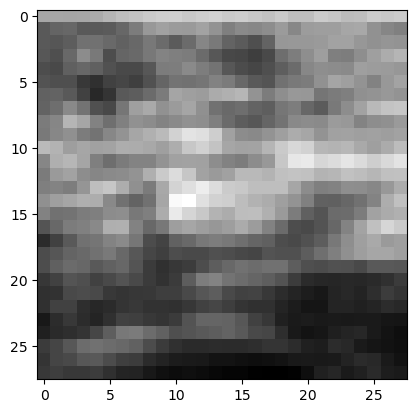

In [10]:
model = Net_28(CONFIG['num_channels'], CONFIG['num_classes']).to(CONFIG['device'])
# _ = train(model, normal_loader, CONFIG['task'])
_ = train(model, perturbed_loader, CONFIG['task'])

DATA: breastmnist
Loader Type: None


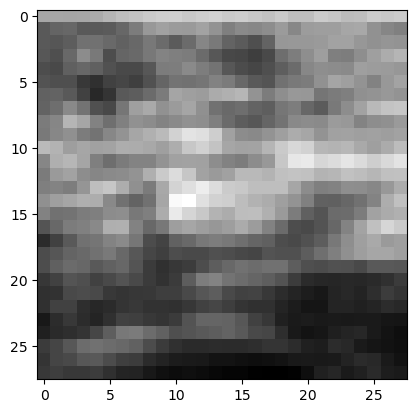

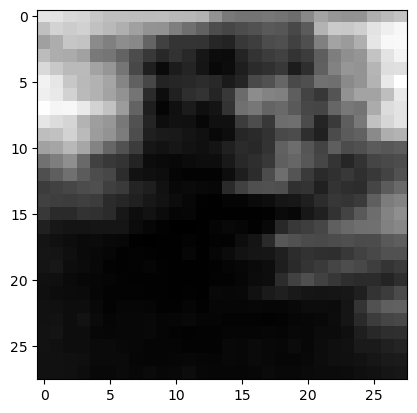

Loader Type: one


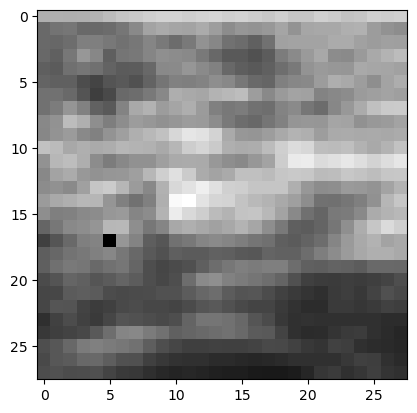

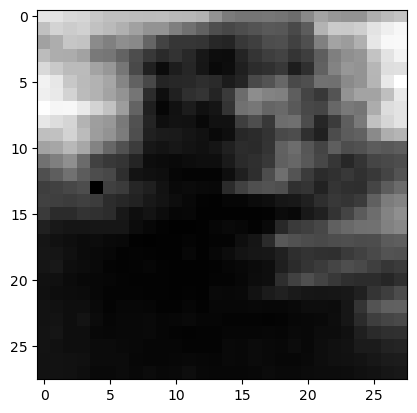

Loader Type: 1


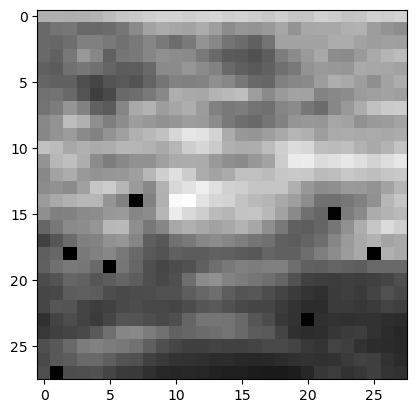

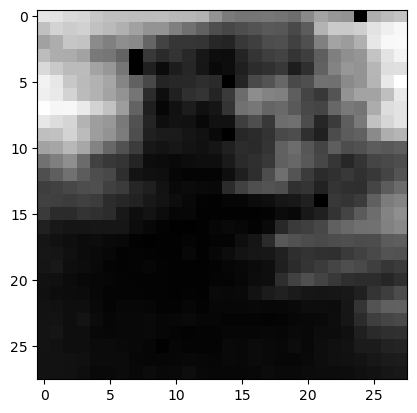

Loader Type: 5


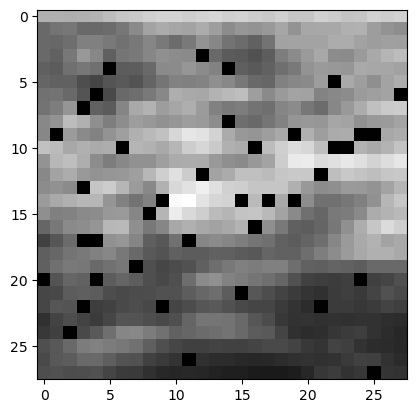

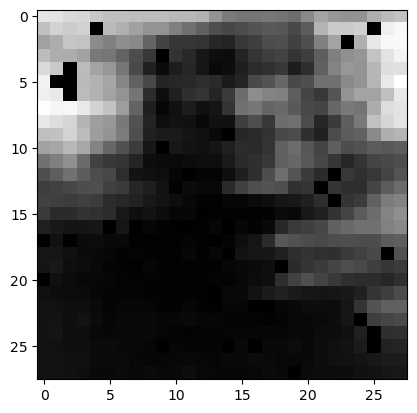

Loader Type: 10


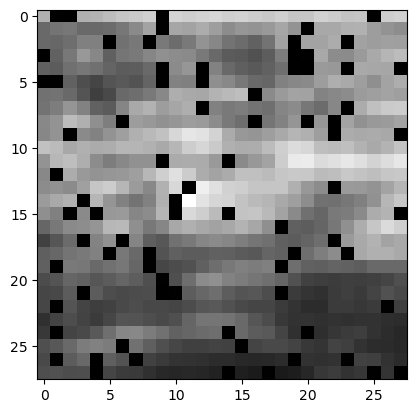

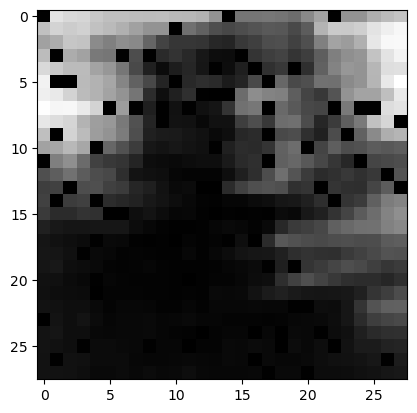

Loader Type: 25


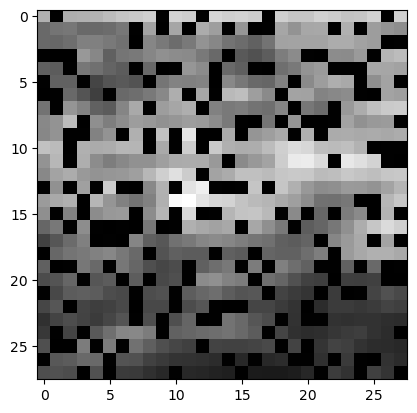

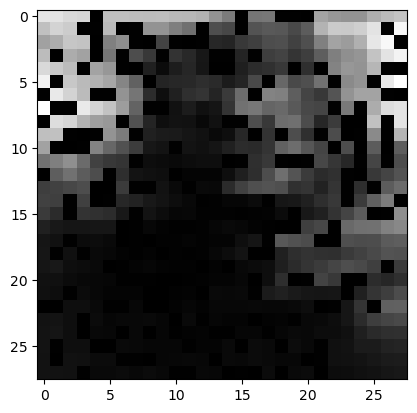

Loader Type: 50


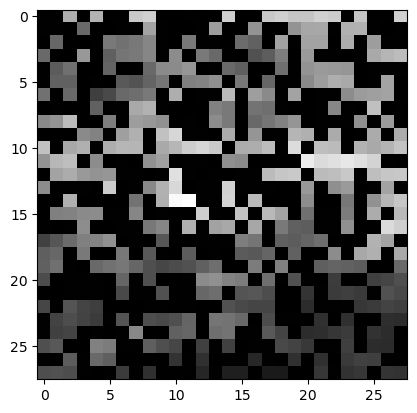

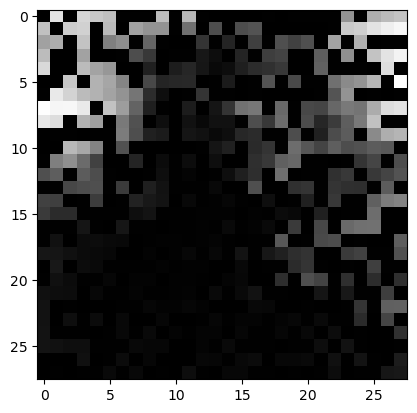

Loader Type: 75


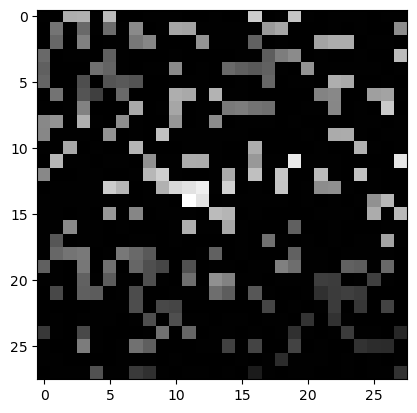

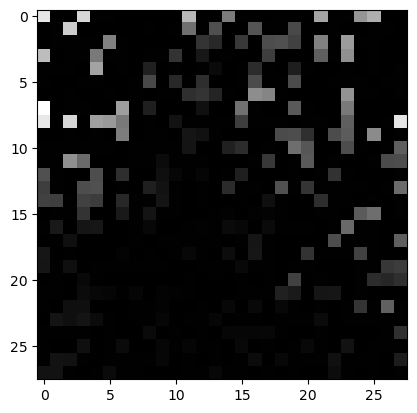

Loader Type: 90


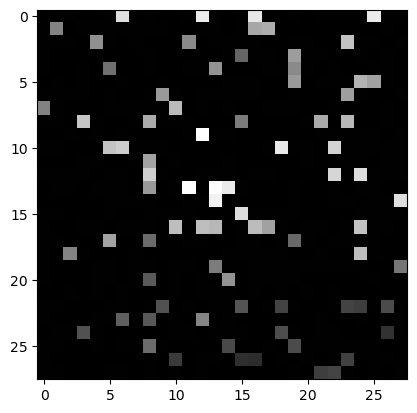

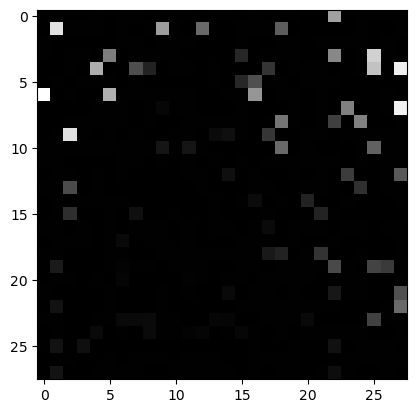

Loader Type: 99


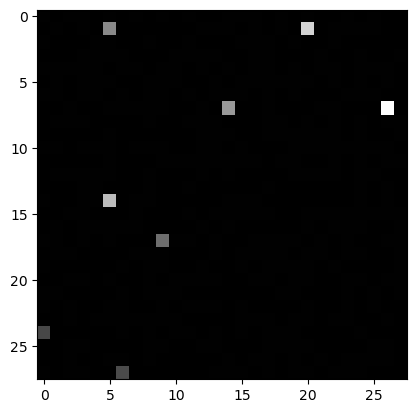

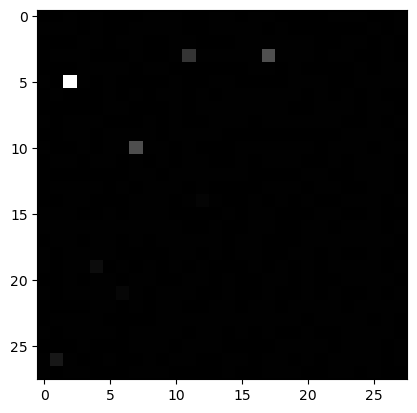

Completed fold 0



In [11]:
from model import Net_28
from config import CONFIG
from typing import Dict
import warnings

warnings.filterwarnings("ignore")

def train_and_evaluate(loaders_dict: Dict[str, Dict]) -> Dict:
    results = {}
    for loader_type in loaders_dict.values():
        print('Loader Type:', loader_type)
        model = Net_28(CONFIG['num_channels'], CONFIG['num_classes']).to(CONFIG['device'])
        train_dataset = MNISTPerturbedDataset(data['train_images'], data['train_labels'], loader_type, transform=create_data_transform(1))
        train_loader = DataLoader(train_dataset, batch_size=20, shuffle=False)
        test_dataset = MNISTPerturbedDataset(data['test_images'], data['test_labels'], loader_type, transform=create_data_transform(1))
        test_loader = DataLoader(test_dataset, batch_size=20, shuffle=False)
        model_trained = train(model, train_loader, CONFIG['task'])
        acc, auc, class_acc = test(model_trained, test_loader, CONFIG['task'])

        results[loader_type] = {
            'accuracy': acc,
            'auc': auc,
            'class_acc': class_acc
        }
        del model, model_trained
    return results

perturbation_configs = {
        'original': None,
        'noisy_1pixel': 'one',
        'noisy_1%': 1,
        'noisy_5%': 5,
        'noisy_10%': 10,
        'noisy_25%': 25,
        'noisy_50%': 50,
        'noisy_75%': 75,
        'noisy_90%': 90,
        'noisy_99%': 99
    }


def main(fold: int):
    dataset_name = CONFIG['data_path'].split('/')[-1].split('.')[0]
    print('DATA:', dataset_name)
    
    results = train_and_evaluate(perturbation_configs)
    process_results(results, dataset_name, fold)

if __name__ == '__main__':
    for fold in range(CONFIG['num_folds']):
        main(fold)
        print(f'Completed fold {fold}\n')